# Advanced Lane Lines Pipeline

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


## Camera Calibration
Finding chessboard corners in an image allows us to determine distortion coefficients to calibrate the camera.

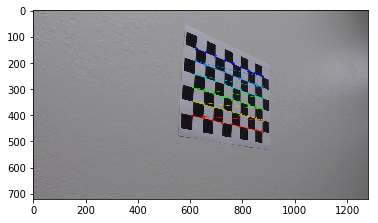

In [2]:
imgs = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

for img_name in imgs:
    img = mpimg.imread(img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners found, add to points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw corners on original image
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        
# Calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)

# Save the camera calibration result for later use
cal_pickle = {}
cal_pickle['mtx'] = mtx
cal_pickle['dist'] = dist
pickle.dump(cal_pickle, open('calibration/cal_pickle.p', 'wb'))


## Distortion Correction

Undistort an image based on the distortion coefficents determined from the chessboard corners found.

In [3]:
# Read in image of the road
img = mpimg.imread('./test_images/test5.jpg')

In [4]:
# Plot before and after images to show the effects of each step of the pipeline
def plot_images(before, after):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(before)
    ax1.set_title('Before', fontsize=50)
    ax2.imshow(after)
    ax2.set_title('After', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

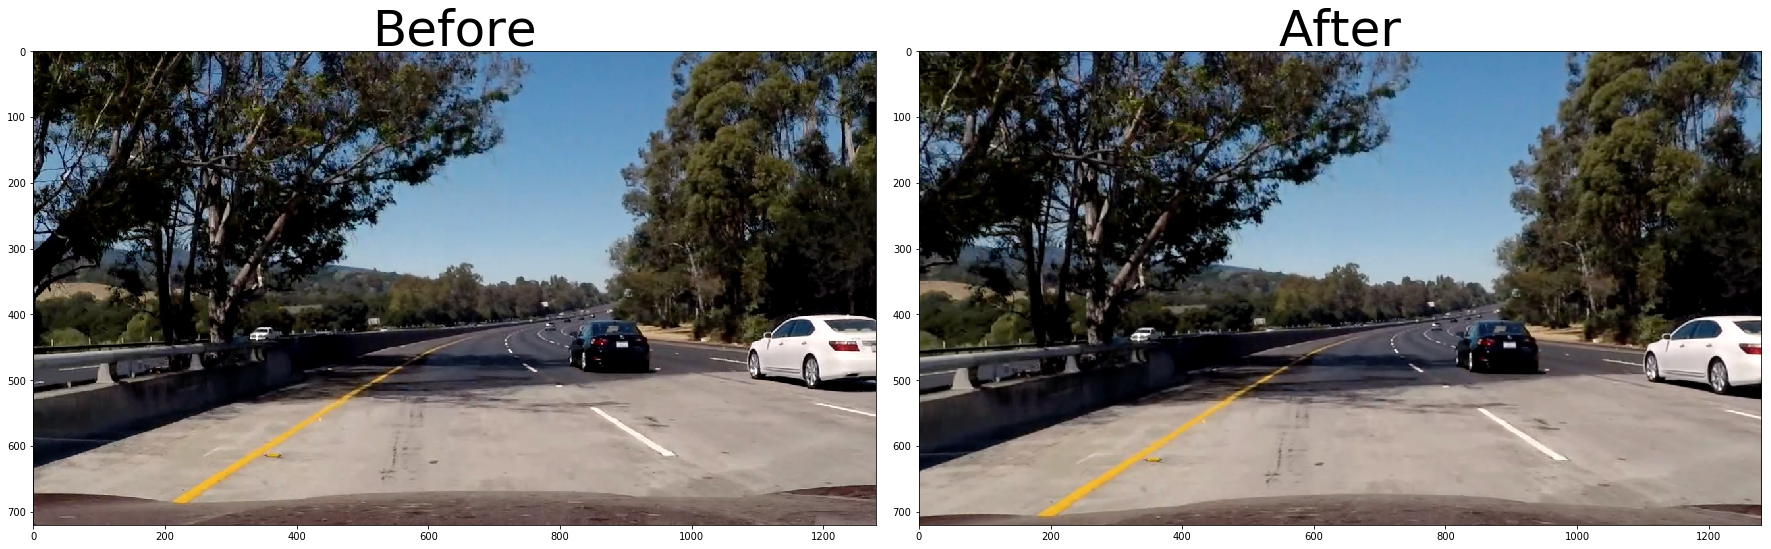

In [5]:
# Undistort test image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Plot original and undistorted images
plot_images(img, undist)


## Color Thresholding

Apply various filters and gradients to an image based on hue, lightness, or saturation values to detect edges.

In [6]:
def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold white mask
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    white_binary = np.zeros_like(white_mask)
    white_binary[(white_mask == 255)] = 1
    
    # Threshold yellow mask
    lower_yellow = np.array([20,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow) 
    yellow_binary = np.zeros_like(yellow_mask)
    yellow_binary[(yellow_mask == 255)] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    sx_color = np.zeros_like(sx_binary)
    sx_color[(sx_binary == 1)] = 255
    
    # Stack each channel
    color_binary = np.dstack((sx_color, yellow_mask, white_mask))
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((sx_binary == 1) | (white_binary == 1) | (yellow_binary == 1))] = 1
    
    return color_binary, combined_binary

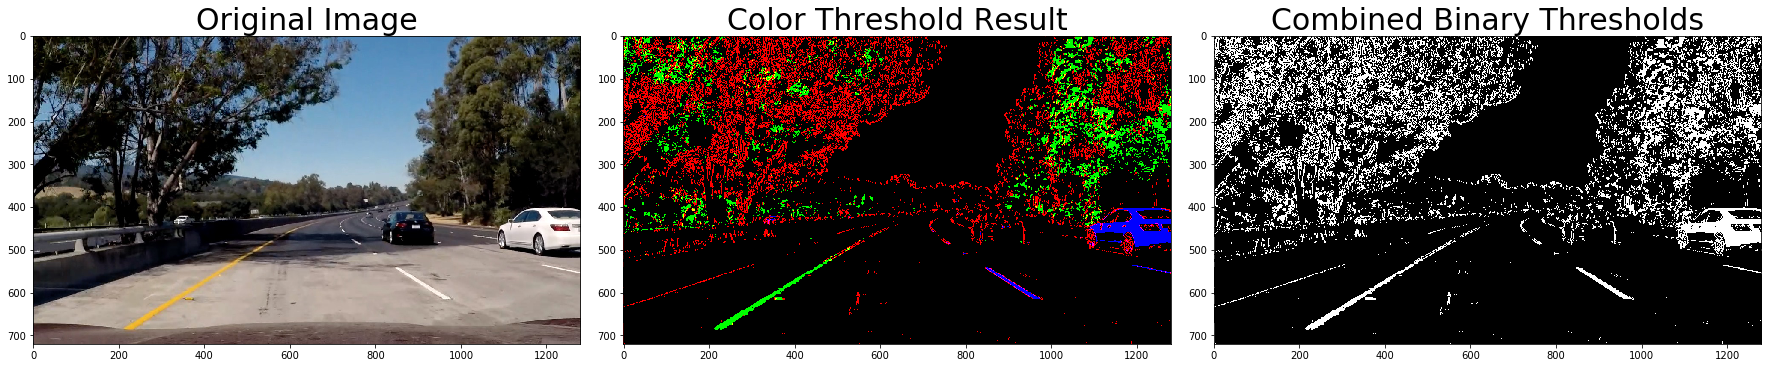

In [7]:
# Threshold road image
color_binary, combined_binary = threshold(img)

# Plot the thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(color_binary)
ax2.set_title('Color Threshold Result', fontsize=30)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined Binary Thresholds', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Perspective Transform

Transform an image to a top down view with transformation points determined from a straight line image.

In [8]:
def warp(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Define 4 source points - obtained from straight line image
    src = np.float32([[580,460], [270,670], [1030,670], [700,460]])
    # Define 4 destination points
    dst = np.float32([[200, 0], [200, 700], [1000, 700], [1000, 0]])
    # Get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Get Minv, the inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst,src)
    # Warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

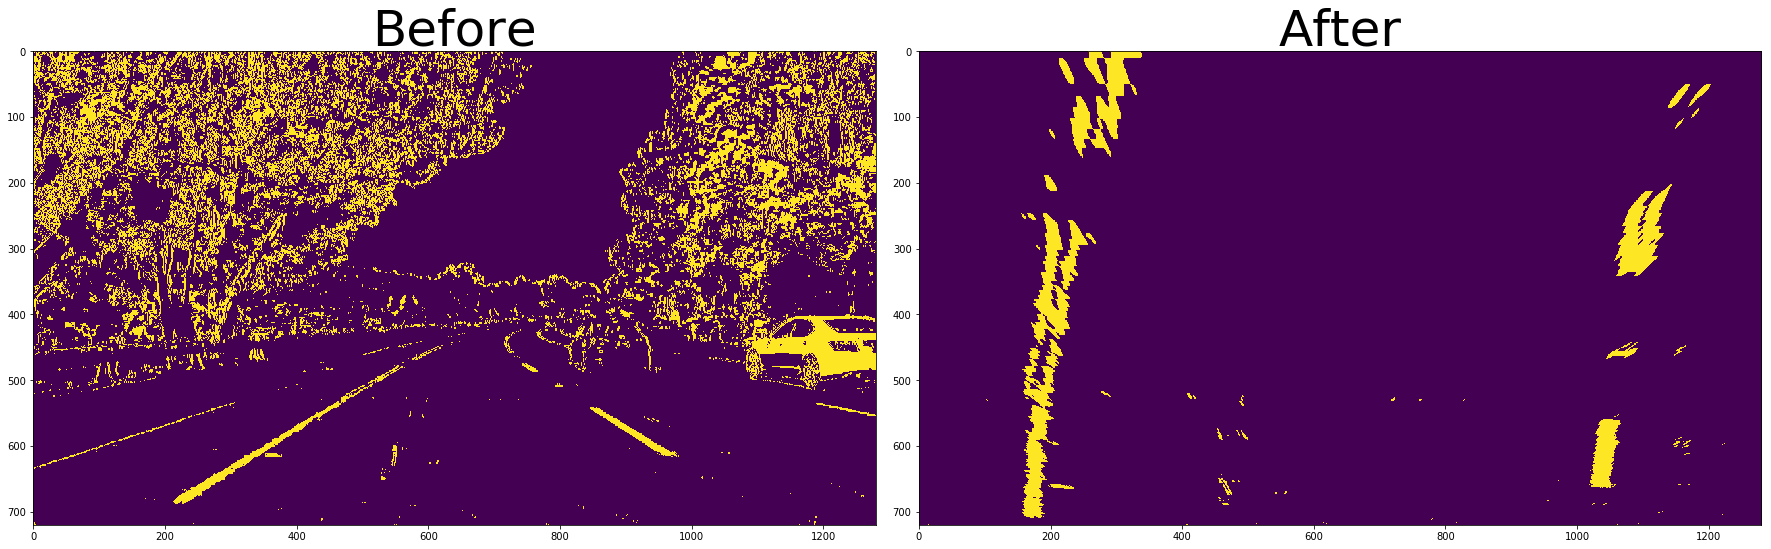

In [9]:
# Undistort and warp the road image
binary_warped, perspective_M, perspective_Minv = warp(combined_binary, mtx, dist)

# Plot original and undistored warped road image
plot_images(combined_binary, binary_warped)


## Lane Lines

A `Line` class allows us to store relavant information on the lanes across each detection iteration.

In [10]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False      
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the last n iterations
        self.last_n_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
    
    # Append a fit to last n iterations and take average
    def append_fit(self, fit):
        self.diffs = fit - self.current_fit
        self.current_fit = fit
        self.last_n_fit.append(fit)
        if(len(self.last_n_fit) > 10):
            self.last_n_fit = self.last_n_fit[1:]
        self.best_fit = np.average(self.last_n_fit, axis=0)

In [11]:
# Initialize both lane objects
left_lane = Line()
right_lane = Line()


## Initial Windowed Search

A windowed histogram search across the image to detect the lane lines' pixels.

In [12]:
# Margin to search for line
SEARCH_MARGIN = 100

# Slide window over image to find lane line
def window_line_search(binary_warped, left_lane, right_lane):    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - SEARCH_MARGIN
        win_xleft_high = leftx_current + SEARCH_MARGIN
        win_xright_low = rightx_current - SEARCH_MARGIN
        win_xright_high = rightx_current + SEARCH_MARGIN
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Store fit results to lanes
    left_lane.append_fit(left_fit)
    right_lane.append_fit(right_fit)
    
    # Color the lanes red and blue on output image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img

In [13]:
def generate_plot(binary_warped, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

(720, 0)

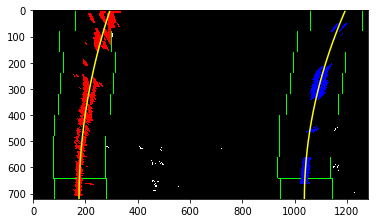

In [14]:
out_img = window_line_search(binary_warped, left_lane, right_lane)
ploty, left_fitx, right_fitx = generate_plot(binary_warped, left_lane.current_fit, right_lane.current_fit)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Subsequent Margin Search 

Once the lane lines have been found with a windowed search, we can search for the lanes within a margin of the intially found lane lines.

In [15]:
# Find line within a margin after initial window search
def find_line(binary_warped, left_lane, right_lane):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_fit = left_lane.current_fit
    right_fit = right_lane.current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - SEARCH_MARGIN)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + SEARCH_MARGIN))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - SEARCH_MARGIN)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + SEARCH_MARGIN)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Store fit results to lanes
    left_lane.append_fit(left_fit)
    right_lane.append_fit(right_fit)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img


(720, 0)

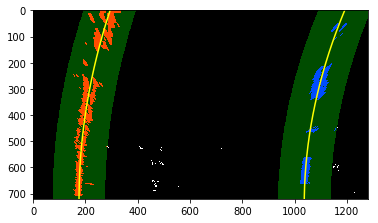

In [16]:
out_img = find_line(binary_warped, left_lane, right_lane)
ploty, left_fitx, right_fitx = generate_plot(binary_warped, left_lane.current_fit, right_lane.current_fit)

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-SEARCH_MARGIN, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+SEARCH_MARGIN, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-SEARCH_MARGIN, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+SEARCH_MARGIN, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
window_img = np.zeros_like(out_img)
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Accuracy Metrics 

We can calculate the radius of curvature of the fitted lane lines as well as the distance of the lanes from the center of the vehicle in order to perform sanity checks on the lane detection. This ensures our detections make sense according to real world values.

In [17]:
# Calculate radius of curvature given fitted lines
def calculate_rad(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

print(calculate_rad(ploty, left_fitx, right_fitx))

(724.29127686591528, 586.51854675516734)


In [18]:
# Calculate distance of lane from center
def calculate_dist_center(img, fitx):
    # Center of image, split in half
    img_center = img.shape[1]/2
    # Absolute difference from vehicle center to lane line
    shift = abs(fitx[-1] - img_center)
    
    return shift * xm_per_pix


## Overlay on Original Image

The detected lane can be drawn onto the original image by performing an inverse perspective transformation to image space.

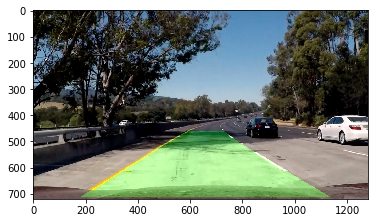

In [19]:
def draw_detection(img, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    return  cv2.addWeighted(img, 1, newwarp, 0.3, 0)

plt.imshow(draw_detection(img, ploty, left_fitx, right_fitx, perspective_Minv))


## Full Pipeline


In [20]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays calculated using cv2.calibrateCamera()
cal_pickle = pickle.load(open('calibration/cal_pickle.p', 'rb'))
mtx = cal_pickle['mtx']
dist = cal_pickle['dist']

In [21]:
# Image pipeline taking in original image, camera calibration matrix, and distortion coefficients
def pipeline(img):
    # Threshold image
    color_threshold, combined_threshold = threshold(img)
    # Distortion correction and perspective transform
    warped, M, Minv = warp(combined_threshold, mtx, dist)
    # Detect lane lines
    if(not(left_lane.detected) or not(right_lane.detected)):
        window_line_search(warped, left_lane, right_lane)
    else:
        find_line(warped, left_lane, right_lane)
    left_lane.detected = True
    right_lane.detected = True
    
    # Generate lane points for plot
    ploty, left_fitx, right_fitx = generate_plot(warped, left_lane.best_fit, right_lane.best_fit)
    
    # Calculate radius of curvature
    left_curverad, right_curverad = calculate_rad(ploty, left_fitx, right_fitx)
    left_lane.radius_of_curvature = left_curverad
    right_lane.radius_of_curvature = right_curverad
    
    # Calculate distance of lanes from center
    left_lane.line_base_pos = calculate_dist_center(img, left_fitx)
    right_lane.line_base_pos = calculate_dist_center(img, right_fitx)
    shift_from_center = abs(left_lane.line_base_pos - right_lane.line_base_pos) / 2
    
    curvature_info = "L: " + str(int(left_curverad)) + "m  R: " + str(int(right_curverad)) + "m"
    img = cv2.putText(img=np.copy(img), 
                      text=curvature_info, 
                      org=(100,100), 
                      fontFace=1, 
                      fontScale=2, 
                      color=(255,255,255), 
                      thickness=3)
    shift_info = "Shift: " + str(shift_from_center) + "m"
    img = cv2.putText(img=np.copy(img), 
                      text=shift_info, 
                      org=(100,150), 
                      fontFace=1, 
                      fontScale=2, 
                      color=(255,255,255), 
                      thickness=3)
    
    return draw_detection(img, ploty, left_fitx, right_fitx, Minv)


## Run Pipeline on Video


In [22]:
# Re-initialize both lane objects
left_lane = Line()
right_lane = Line()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
output_clip = clip1.fl_image(pipeline)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:11<00:00,  5.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 43s, sys: 1min 1s, total: 4min 44s
Wall time: 4min 12s
